# Import

In [1]:
# install dependencies
!pip3 install fastfuels==0.5.3  s3fs==0.5.2 fsspec==0.8.3

You should consider upgrading via the 'C:\Users\hirok\AppData\Local\Programs\Python\Python39\python.exe -m pip install --upgrade pip' command.


In [2]:
import fastfuels
import matplotlib.pyplot as plt
import numpy as np
from collections import Counter

In [3]:
fio = fastfuels.open('https://wifire-data.sdsc.edu:9000/fastfuels/index.fio', ftype='s3', username='fastfuels', password='Treatment##Buffet')
fio.cache_limit = 1e14

# Question

- What percentage of a tile (30x30m) is grass-shrub vs shrub and how does that constitute the label its given
- (side question) How to label a 1x1m voxel

- On a reduced scale I tried to look at an area where two different surface types meet (seen below). The two surfaces here are Grass-Shrub on the right which is in a greenish color and Shrub on the left side which is in a brownish color. For this initial model I created an assumption that these two different types of surfaces would be the primary surface types for the tiles that lie on the border that have an ambiguity in its sav coloring (half green half brown) seen below in the second picture. I want to determine what percentage of these ambiogus tiles are grass-shrub vs shrub.
- To identify the percentages of these ambiogus tiles my approach was to label each 1x1m voxel in the tile and label it as grass-shrub or shrub then calculate each of its percentage in the tile.
- To label each voxel I got the sav from a pure shrub area and the sav from a pure grass-shrub area which were both singular numbers because they only had landfire data labelling. (Further images down below). Then for each voxel in the ambiguous tiles I looked at their sav and labeled it grass-shrub or shrub depending on how close their sav values were to either surface types. I then counted the number of grass-shrub vs shrub voxels and calculated their percentages.


- terminology
- Grass-Shrub = GS
- Shrub = SH
- voxel = 1m^3 cube
- tile = 30m^2 area *could be 2d flat area or could be 3d if other inputs besides Landfire is inside

# Map

Landfire labels. Shrub on the left and grass-shrub on the right. The tiles that border them are unambiguous. Has a clear binary label of GS or SH.
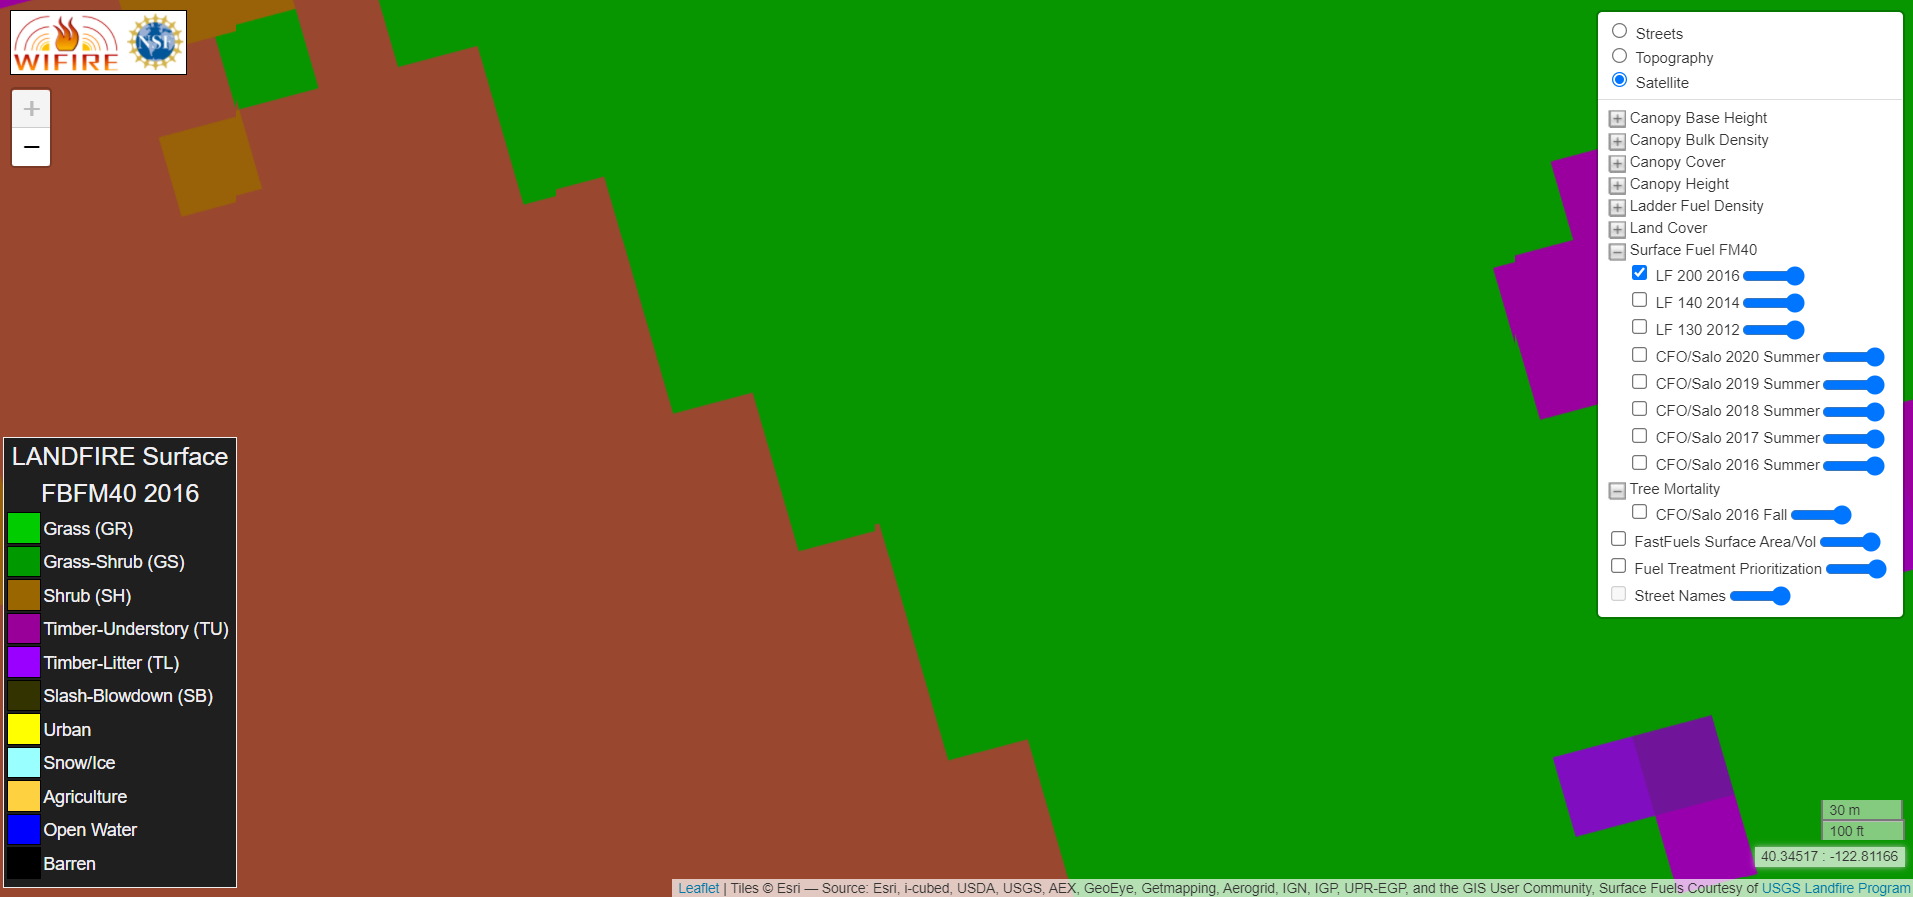

While Landfire labels have unambigious square tiles, the corresponding sav values are ambiguous and need to be look at more closely for its makeup and what percentage of it is GS or SH

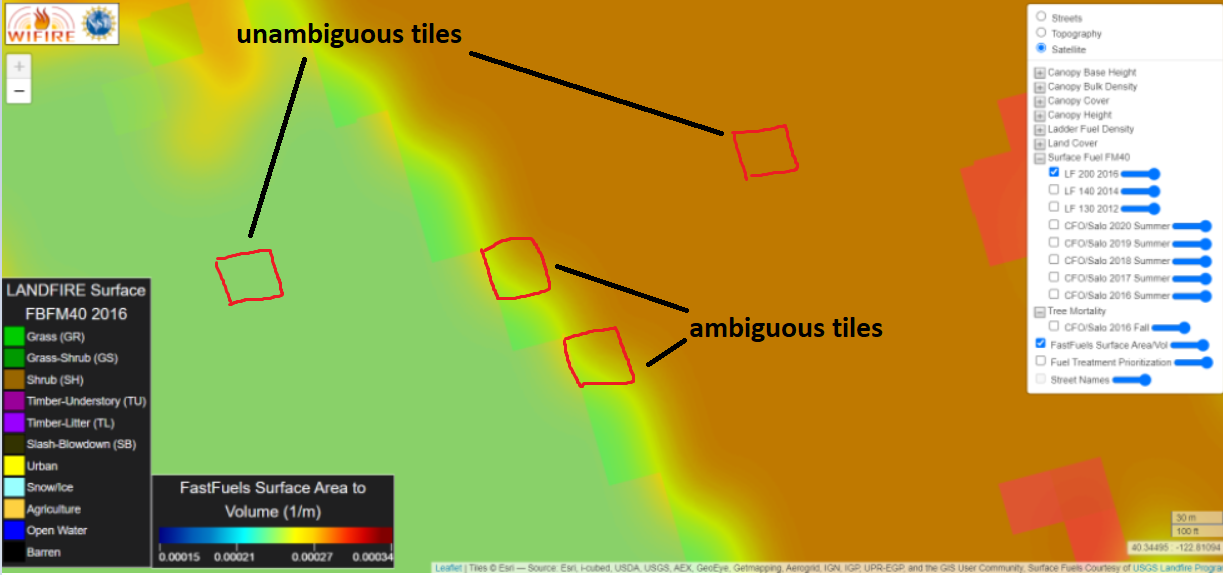

# Grass-Shrub (122)

Lets look at a pure GS tile on the right hand side
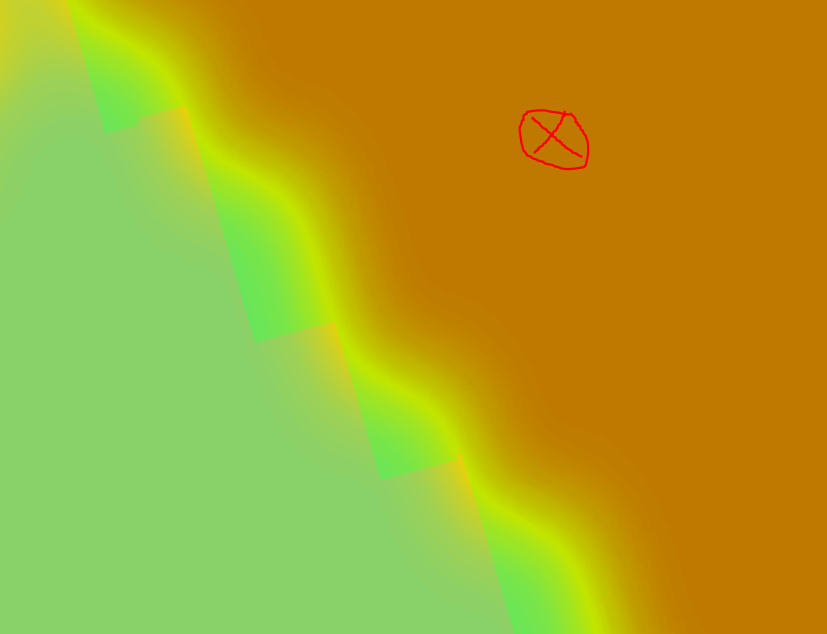

Bounding box query found in single source: ca.fio


C:\Users\hirok\AppData\Local\Programs\Python\Python39\lib\site-packages\pyvista\core\dataset.py:1332: PyvistaDeprecationWarning: Use of `cell_arrays` is deprecated. Use `cell_data` instead.
  warnings.warn(
C:\Users\hirok\AppData\Local\Programs\Python\Python39\lib\site-packages\pyvista\jupyter\notebook.py:60: UserWarning: Failed to use notebook backend: 

Please install `ipyvtklink` to use this feature: https://github.com/Kitware/ipyvtklink

Falling back to a static output.
  warnings.warn(f'Failed to use notebook backend: \n\n{e}\n\n'


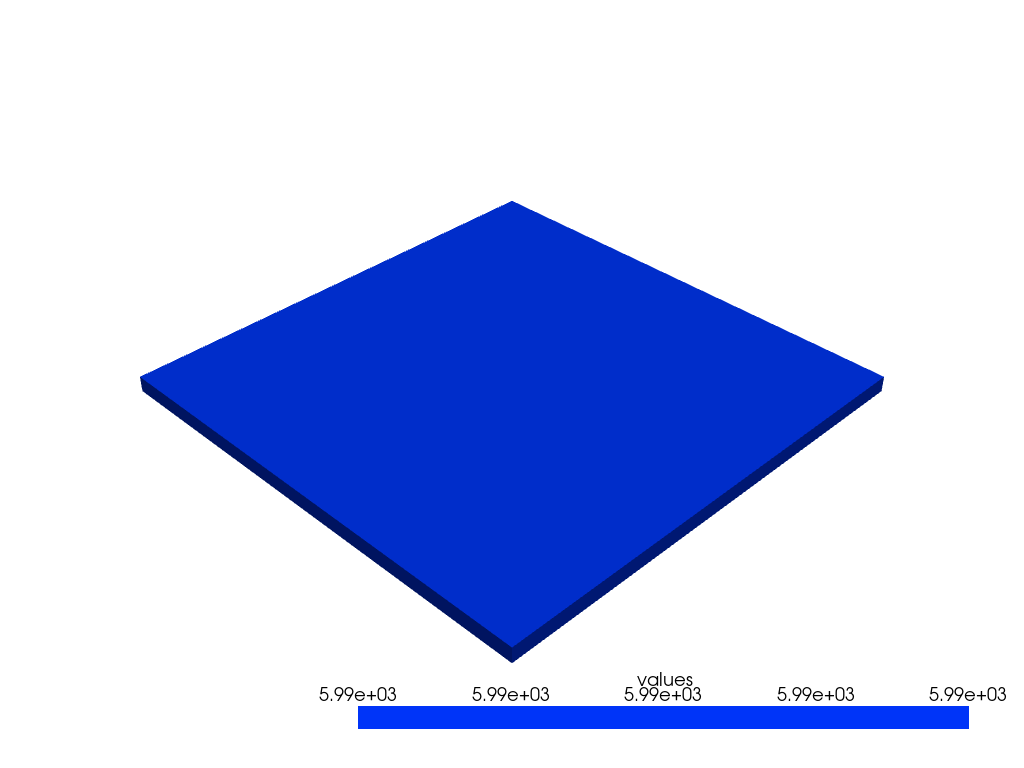

In [4]:
lat = 40.34444
lon = -122.80706
roi = fio.query(lon, lat, 15)
roi.view('sav')

In [5]:
sav_data = roi.data_dict['sav']
np.unique(sav_data)

array([-1.000000e+00,  5.992157e+03], dtype=float32)

In [6]:
grass_shrub = np.unique(sav_data)[1]
grass_shrub

5992.157

We take the unique sav values of the tile and find that there are only two values. -1 which is the air and which we can ignore, and 5992.157 which is the pure GS sav value for the tile. We will use this values to help categorize voxel values as GS.

# Shrub (147)

Lets look at a SH tile on the left hand side and do the same process.
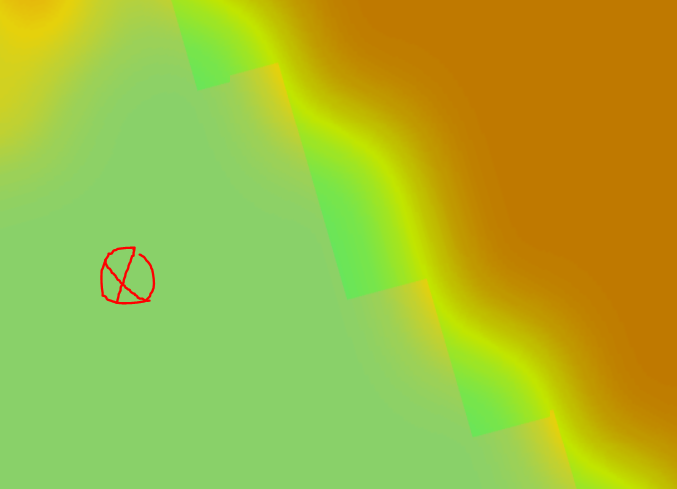

Bounding box query found in single source: ca.fio


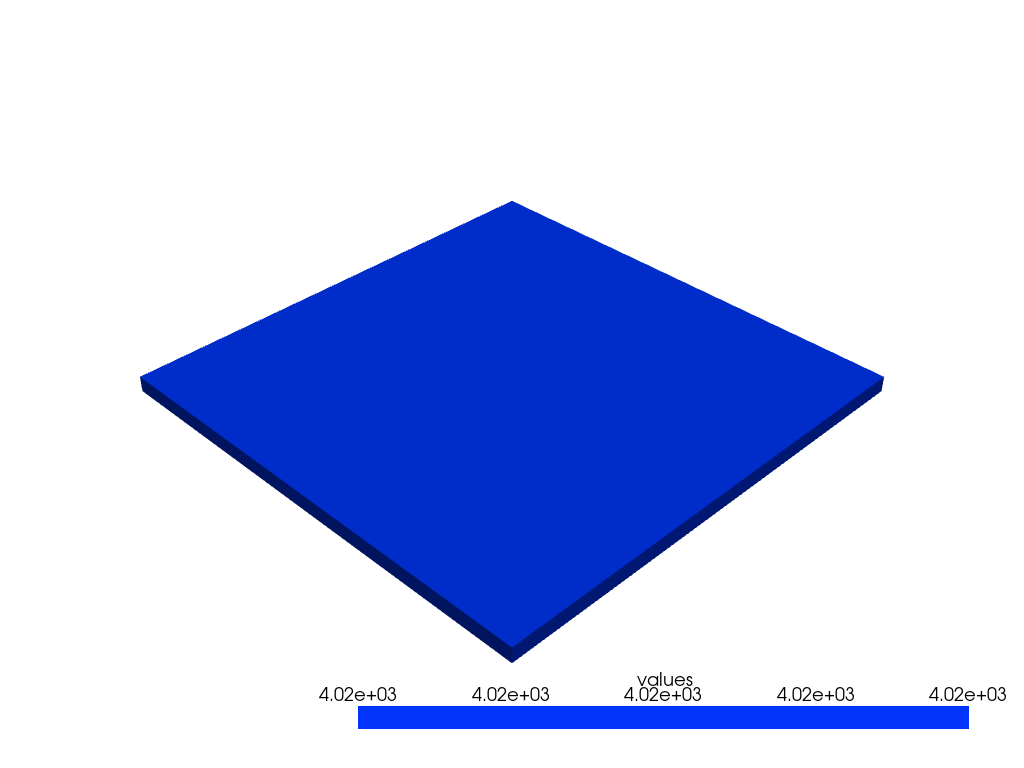

In [7]:
lat = 40.34371
lon = -122.80985
roi = fio.query(lon, lat, 15)
roi.view('sav')

In [8]:
sav_data = roi.data_dict['sav']
np.unique(sav_data)

array([-1.0000000e+00,  4.0156865e+03], dtype=float32)

In [9]:
shrub = np.unique(sav_data)[1]
shrub

4015.6865

Again we see only two unique values for this 30x30m tile (-1, 4014.6865). We again ignore the -1 air value and use the sav value of 4014.6865 to classify future voxels as SH.

Let us now look at a tile where there are more than one unique sav value and where it remains ambiguous. We will look at each voxel in the tile and label it as either GS or SH depending on how close its sav value is to either the pure GS or SH sav value.

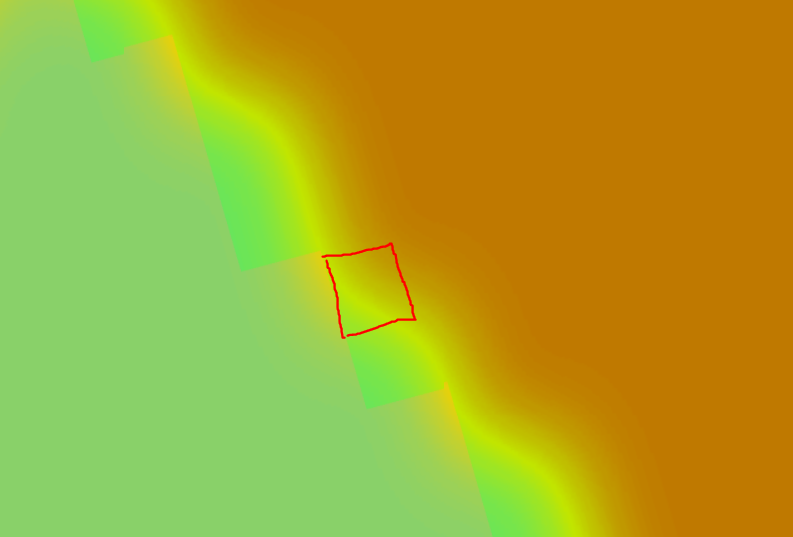

This function will take in a lat and lon and the sav values of the two labels 5992.157 for GS and 4014.6865 for SH and spit out the proportion of the tile that is GS and SH as well as the image of the tile for reference. We remember to remove all of the -1 air values out of the data since it can bias our results and is not needed to classify the voxels of the tile.

In [15]:
def label_tile(lat, lon, labelA, labelB):
    roi = fio.query(lon, lat, 15)
    roi.view('sav')
    
    sav_data = roi.data_dict['sav']
    sav_data_list = []
    for x in sav_data:
        for y in x:
            for z in y:
                sav_data_list.append(z)
    sav_data_list = [x for x in sav_data_list if x != -1]
    
    a = 0
    b = 0
    for x in sav_data_list:
        
        if abs(labelA - x) < abs(labelB - x):
            a += 1
        elif abs(labelA - x) > abs(labelB - x):
            b += 1
    return (a/(a+b), b/(a+b))

Lets test the function.

Bounding box query found in single source: ca.fio


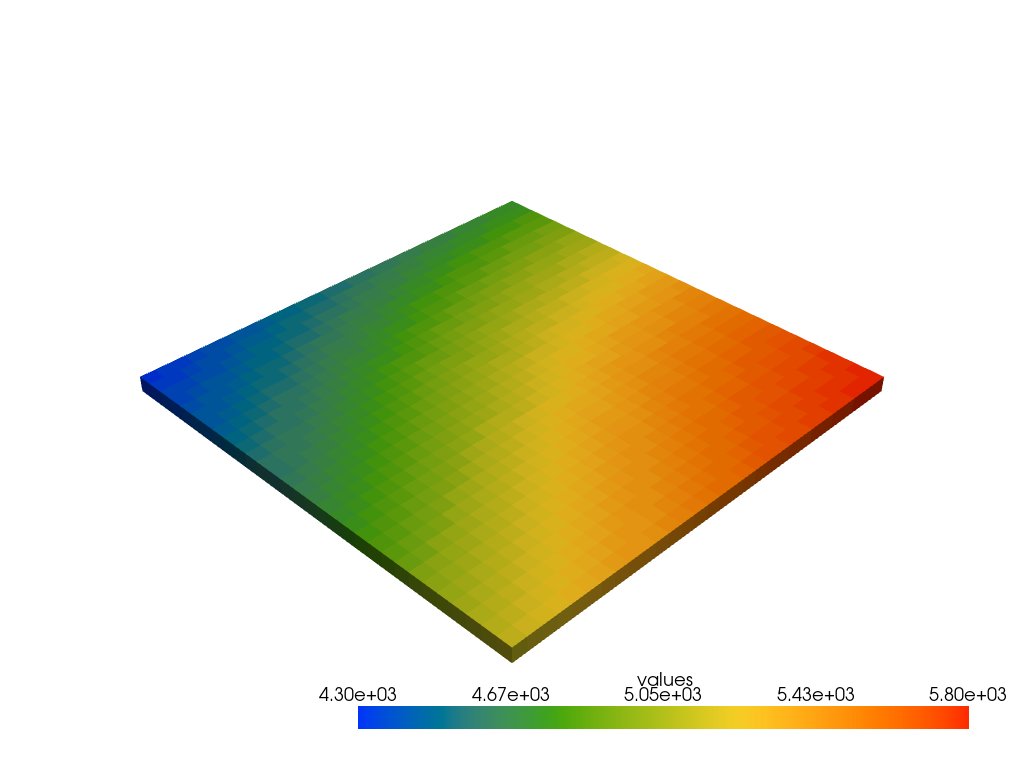

(0.5511111111111111, 0.4488888888888889)

In [16]:
label_tile(40.3438,-122.80825, grass_shrub, shrub)

From the results we see that this tile is 55.11% GS and 44.88% SH. We test the function again two more times and take note of the % values of the different tiles

Bounding box query found in single source: ca.fio


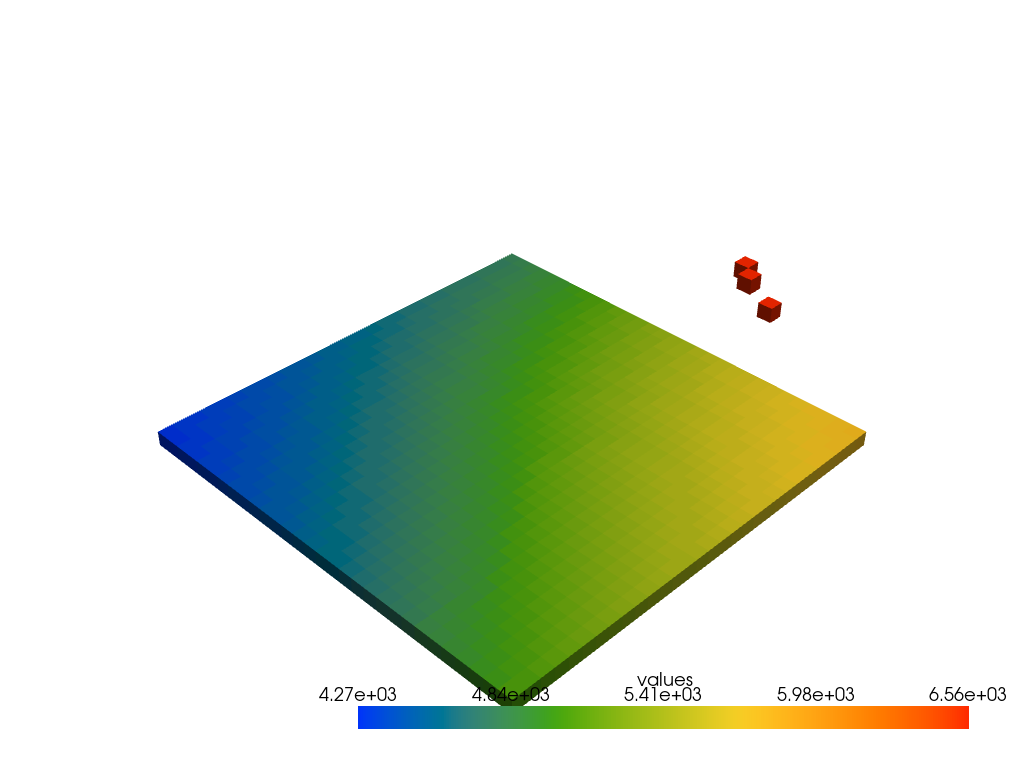

(0.4529346622369878, 0.5470653377630121)

In [17]:
label_tile(40.34491,-122.80944, grass_shrub, shrub)

Bounding box query found in single source: ca.fio


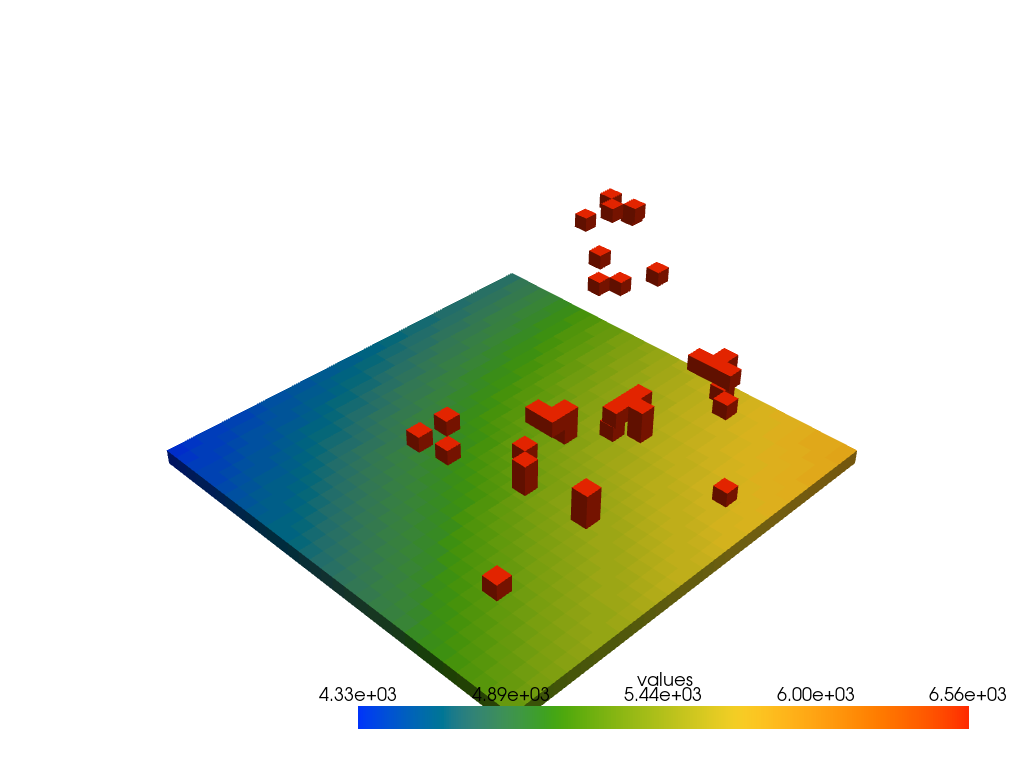

(0.6074866310160428, 0.3925133689839572)

In [18]:
label_tile(40.34198,-122.80644, grass_shrub, shrub)

We see that for these tiles the percetage of grass-shrub vs shrub is fairly evenly distributed. Though some lie as more grass-shrub favored or more shrub favored there were no extreme values in these 3 results. This may not be true of all of the amibiguous tiles however. While some were more grass-shrub and some were more shrub, the tiles tested were all labeled 
grass-shrub by Landfire which may show some of the inaccuracy of this type of labeling. 

# Closing Remarks

- This is a naive approach in classifying 1m voxels and is merely an introducotry way to explore the makeup and percentages of 30x30m tiles. As we can see not all of the results were as expected in labelling the tiles either grass-shrub or shrub. The scope of this notebook is limited to the comparison of grass-shrub and shrub labels in this area where there are no other labels. To further expand the scope of this type of modeling and make it more accurate we would try to find the pure sav values of all the labeled surface types in addition to grass-shrub and shrub such as grass, timber, water, agriculture, urban, etc. Then use the same process here of finding the nearest sav value to each voxel and labeling it with the corresponding surface type. In this way we can expand to other surface types and find different % values of areas with more surface types/ambiguity.
- Possible problems do arise however. If a tile is not 2d and has extra inputs such as with the red voxels in the image above, these voxels usually have a considerably different sav value from the one on its foreground and could be mislabelled. This may also not be a problem however. If these extra voxels, usually trees/other biota, have higher sav values, then it could more correctly be labelled "timber" with a more accurate sav value even if this timber is in a chapparral.
- One solution to this problem could be only looking at sav values from the 2d floor tiles and ignoring the voxels above which could be a large or small part of the 30x30m tile depending on where we look. In instances where the above voxels are minimal there could be little problem but with areas with high number of above voxels this could be a problem. Another way could be classifying the above voxels serpately from the floor tile voxels and computing an aggregate of both of these labels/percentages.